In [72]:
%matplotlib inline
%cd /home/wallar/projects/nyc-taxi-analysis/

/home/wallar/projects/nyc-taxi-analysis


In [336]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [354]:
def load_data(p_st, d_st):
    fname = "data/ts/{}-{}.txt".format(p_st, d_st)
    df_options = {"names": ["datetime"],
                  "parse_dates": ["datetime"],
                  "infer_datetime_format": True,
                  "header": None,
                  "squeeze": True,
                  "skip_blank_lines": True,
                  "index_col": 0}
    df = pd.read_csv(fname, **df_options)
    df.sort_index(inplace=True)
    return df

In [361]:
import tqdm
from itertools import product
N = 101
rng = tqdm.tqdm_notebook(product(xrange(N), xrange(N), xrange(N), xrange(N)), total=N ** 4)
cmat = np.zeros((N, N, N, N))
for p0, d0, p1, d1 in rng:
    try:
        df0 = load_data(p0, d0)
        df1 = load_data(p1, d1)
        ts0 = map(lambda v: v.value, df0.index)
        ts1 = map(lambda v: v.value, df0.index)
        cor = np.correlate(ts0, ts1)
        cmat[p0, d0, p1, d1] = cor
    except IOError:
        pass

KeyboardInterrupt: 

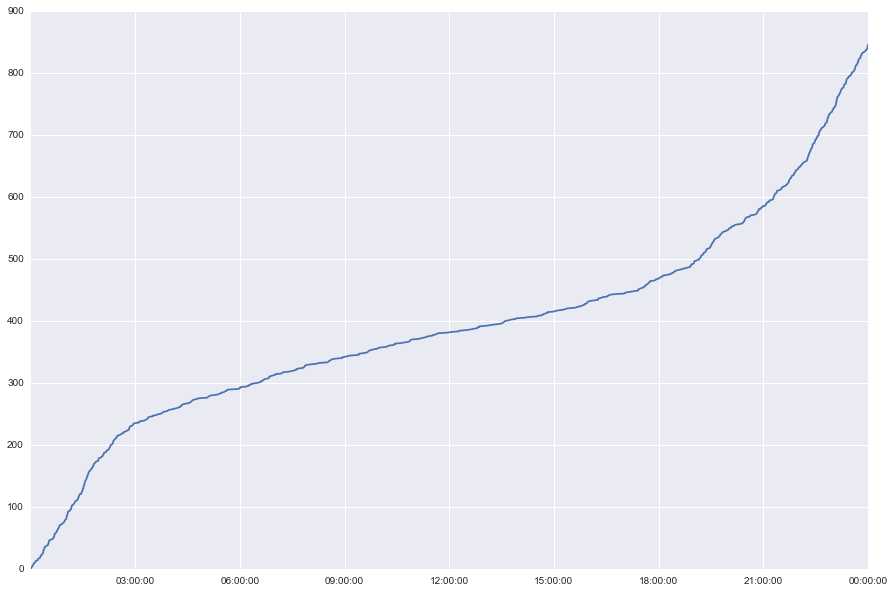

In [355]:
df = load_data(p, d)
df = df["2014-08-05 00:00":"2014-08-06 00:00"]
fig, axs = plt.subplots(figsize=(15, 10))
plt.plot(df.index, range(df.shape[0]))